In [1]:
import pandas as pd
import numpy as np
from openap import aero

import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy.feature import BORDERS

from openap import top

## Define objective function

Here I am using a three hump camel function to simulate a complex cost gird. You can also test with the six hump_camel function for more local minima.

In [2]:
def gaussian(x, y):
    return -np.exp(-x**2 - y**2)


def three_hump_camel(x, y):
    return 2 * x**2 - 1.05 * x**4 + x**6 / 6 + x * y + y**2


def six_hump_camel(x, y):
    return (4 - 2.1 * x**2 + x**4 / 3) * x**2 + x * (y) + (-4 + 4 * (y)**2) * (y)**2


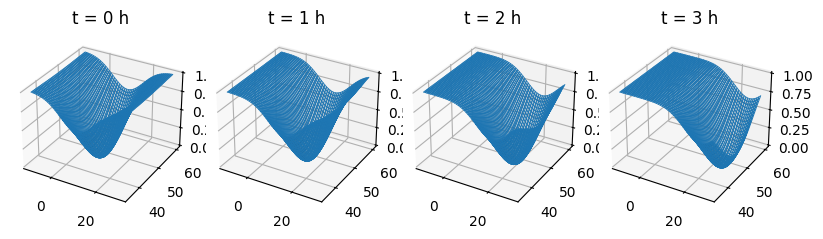

In [3]:
# search ranges for the hump functions
x = np.linspace(-2, 2, 50)
y = np.linspace(-1, 1, 50)
z = np.linspace(0, 13_000, 10)
ts = np.arange(0, 4 * 3600, 3600)

X, Y, Z = np.meshgrid(x, y, z)

V = np.zeros((len(x), len(y), len(z), len(ts)))

# shift the minima with time
for i, ts_ in enumerate(ts):
    v = gaussian(X - i * 0.5, Y)
    V[:, :, :, i] = v

V = V - V.min()

# re-scale to our lon/lat grid
x_ = np.interp(x, (min(x), max(x)), (-10, 30))
y_ = np.interp(y, (min(y), max(y)), (35, 60))
X, Y, Z, TS = np.meshgrid(x_, y_, z, ts)

fig, axes = plt.subplots(1, 4, figsize=(8, 6), subplot_kw={"projection": "3d"})
axes = axes.flatten()

for i in range(len(ts)):
    ax = axes[i]
    ax.plot_surface(
        X[:, :, 0, i],
        Y[:, :, 0, i],
        V[:, :, 0, i],
        edgecolor="tab:blue",
        lw=0.5,
        alpha=0.3,
    )
    ax.set_title(f"t = {i} h")

plt.tight_layout()
plt.show()

## construct the cost data frame

Your own cost should have the same structure as follows

In [4]:
df_cost = pd.DataFrame(
    np.array([X, Y, Z, TS, V]).reshape(5, -1).T,
    columns=["longitude", "latitude", "h", "ts", "cost"],
).sort_values(["ts", "h", "latitude", "longitude"], ascending=True)
# ).sort_values(["longitude", "latitude", "h", "ts"])

df_cost

,longitude,latitude,h,ts,cost
0,-10.000000,35.0,0.0,0.0,0.992742
40,-9.183673,35.0,0.0,0.0,0.990202
80,-8.367347,35.0,0.0,0.0,0.986874
120,-7.551020,35.0,0.0,0.0,0.982579
160,-6.734694,35.0,0.0,0.0,0.977120
...,...,...,...,...,...
99839,26.734694,60.0,13000.0,10800.0,0.642505
99879,27.551020,60.0,13000.0,10800.0,0.654778
99919,28.367347,60.0,13000.0,10800.0,0.671036
99959,29.183673,60.0,13000.0,10800.0,0.690670


## Set up the new objective function

General steps to set you own objective function / cost grid:

1. generate the interpolate model (linear) based on the grid data
2. define the objective function
3. pass the new objective function and interplant model to optimizer's `trajectory()` generator

(Note: this process can take a while, ~1 minute with a modern computer)

In [5]:
optimizer = top.Cruise("A320", "EHAM", "LGAV", m0=0.85)
optimizer.init_conditions(h_min=32_000 * aero.ft, h_max=36_000 * aero.ft)
optimizer.fix_cruise_altitude()
optimizer.setup_dc(nodes=40)
optimizer.debug = False

# the inpterpolant required for the cost grid
interpolant = top.tools.interp_grid(
    df_cost.longitude.unique(),
    df_cost.latitude.unique(),
    df_cost.h.unique(),
    df_cost.ts.unique(),
    df_cost.cost,
    shape="linear",
)


def obj_grid(x, u, dt, **kwargs):
    """The final cost is the compound of the 4d grid cost and fuel """
    # grid cost unit is: cost/time
    grid_cost = optimizer.obj_grid_cost(x, u, dt, **kwargs) * dt
    fuel_cost = optimizer.obj_fuel(x, u, dt, **kwargs)
    return grid_cost * 2 + fuel_cost

# generate the flight trajectory
# interpolant is passed to trajectory() and then to obj_grid() internally
flight = optimizer.trajectory(
    objective=obj_grid,
    interpolant=interpolant,
    h_min=32_000 * aero.ft,
    h_max=36_000 * aero.ft,
)

## Visualize the trajectory

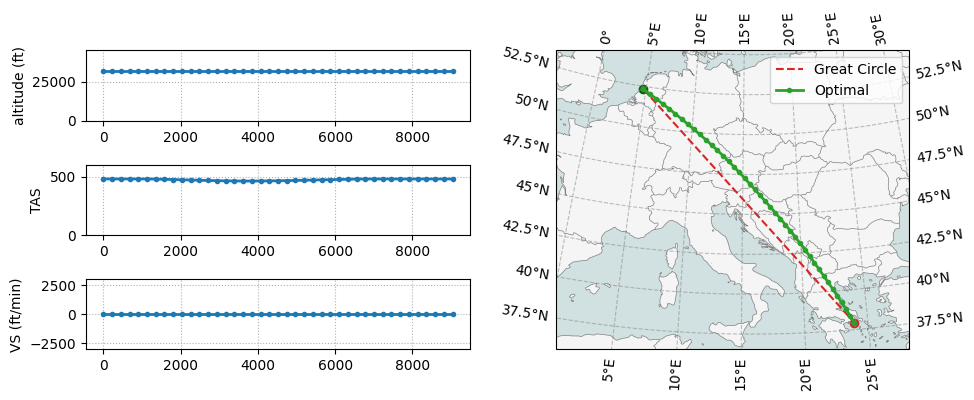

In [6]:
top.vis.trajectory(flight)
plt.show()

### Visualize the projected 4D cost along the trajectory 

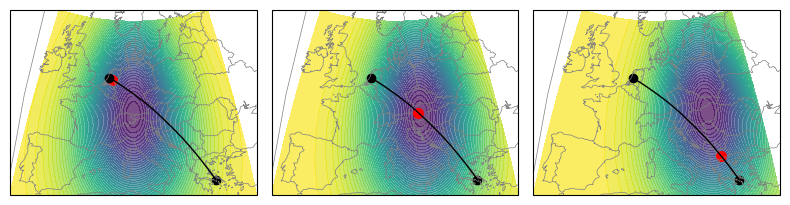

In [7]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(8, 6),
    subplot_kw=dict(
        projection=ccrs.TransverseMercator(central_longitude=10, central_latitude=50)
    ),
)

for t in range(3):
    ax = axes[t]
    ax.set_extent([-10, 30, 35, 60])
    ax.add_feature(BORDERS, lw=0.5, color="gray")
    # ax.gridlines(draw_labels=True, color="gray", alpha=0.5, ls="--")
    ax.coastlines(resolution="50m", lw=0.5, color="gray")

    df_cost_pivot = df_cost.query(f"h==0 and ts=={t*3600}").pivot(
        index="latitude", columns="longitude", values="cost"
    )

    lat, lon, val = df_cost_pivot.index.values, df_cost_pivot.columns.values, df_cost_pivot.values

    ax.contourf(
        lon,
        lat,
        val,
        transform=ccrs.PlateCarree(),
        alpha=0.7,
        cmap="viridis",
        levels=50,
    )

    current_data = flight.query(f"{t*3600}<ts<{t*3600+600}").iloc[0]

    ax.scatter(
        current_data.longitude,
        current_data.latitude,
        color="r",
        lw=2,
        transform=ccrs.PlateCarree(),
    )

    ax.plot(flight.longitude, flight.latitude, color="k", lw=1, transform=ccrs.PlateCarree())

    ax.scatter(flight.longitude.iloc[0], flight.latitude.iloc[0], c="k", transform=ccrs.PlateCarree())
    ax.scatter(flight.longitude.iloc[-1], flight.latitude.iloc[-1], c="k", transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()
